In [1]:
import numpy as np
import cupy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Task 12. Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram. <strong>[Hint: how to represent the histogram](https://cdn.datamentor.io/wp-content/uploads/2017/11/r-histogram.png)</strong>

In [2]:
@cp.fuse()
def z(x):
    return cp.sin(3 * x) - 0.5

@cp.fuse()
def f(x):
    return (cp.power(z(x), 2) + cp.power(z(x), 3) - 200 * cp.power(z(x), 4)) * cp.sin(1e5*(x + 0.5))

n_points = 10000000
x = cp.linspace(0,1, n_points)
y = f(x)
f_min = y.min()
f_max = y.max()
delta = 0.1 * (f_max - f_min)
print('Min: {}. Max {}. delta {}.'.format(f_min, f_max, delta))


Min: -12.365544666168107. Max 12.374912294071224. delta 2.4740456960239334.


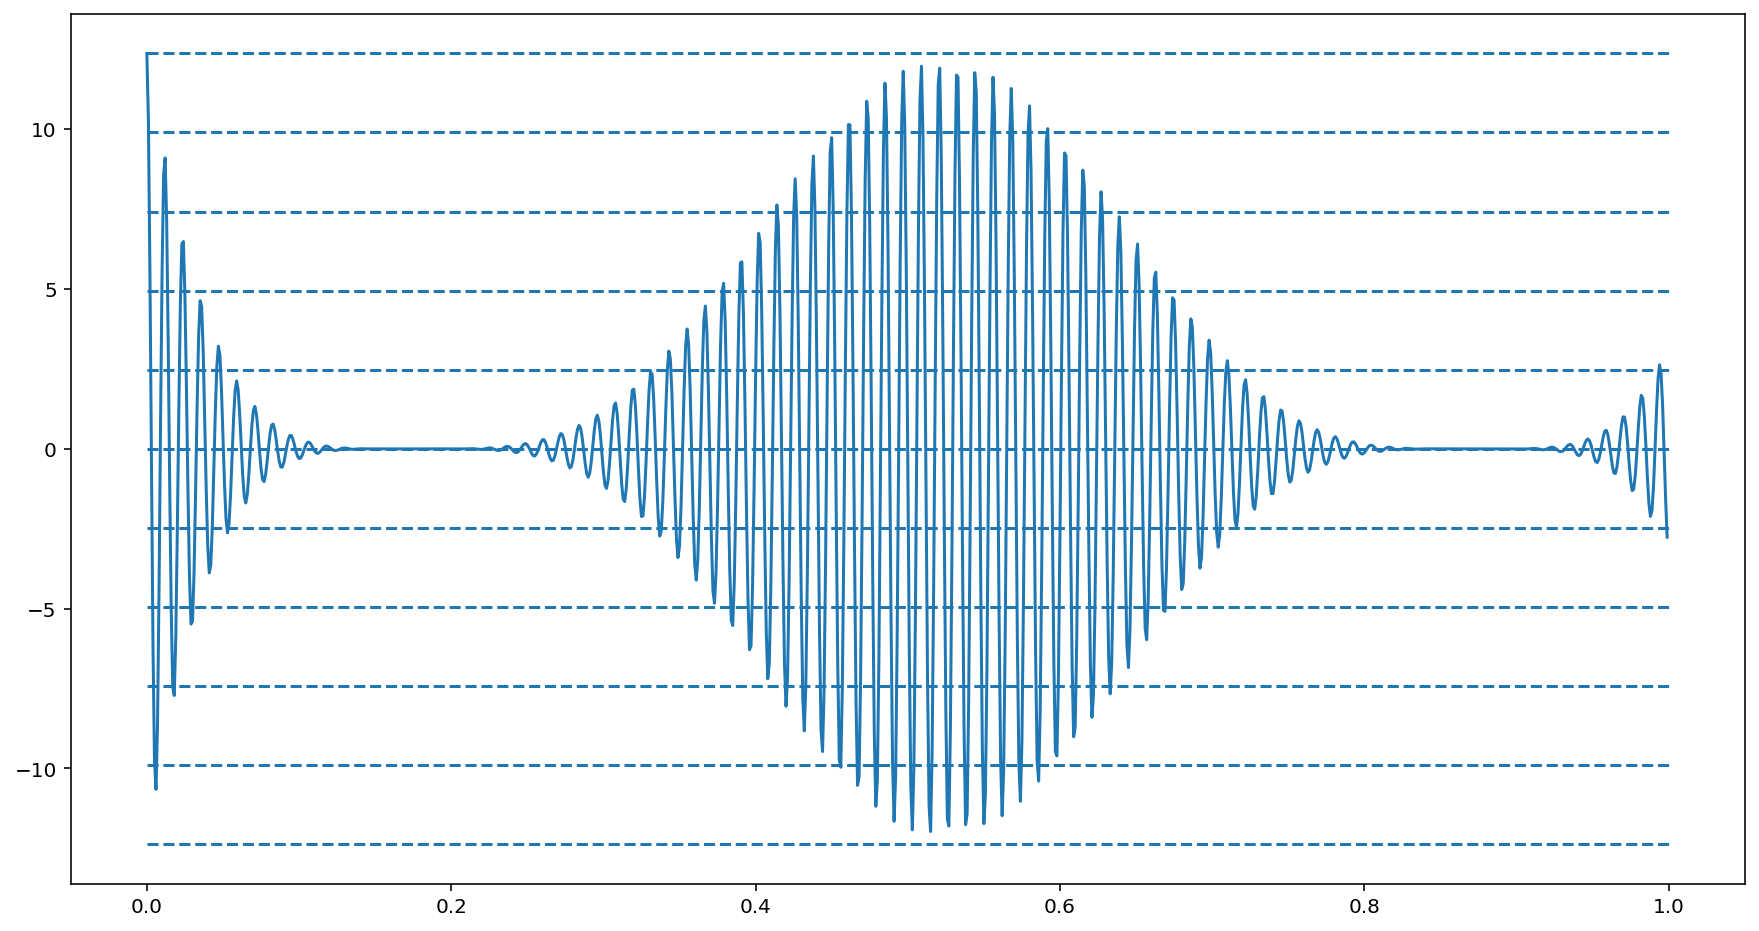

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(x.tolist()[::10000], y.tolist()[::10000]);
plt.hlines([float(f_min + i*delta) for i in range(11)], 0, 1, linestyles='dashed')

Let's benchmark function we will use to split our data into bins.

In [4]:
np_y = cp.asnumpy(y)
%timeit y[y > 5]
%timeit np_y[np_y > 5]

816 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.31 ms ± 60.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


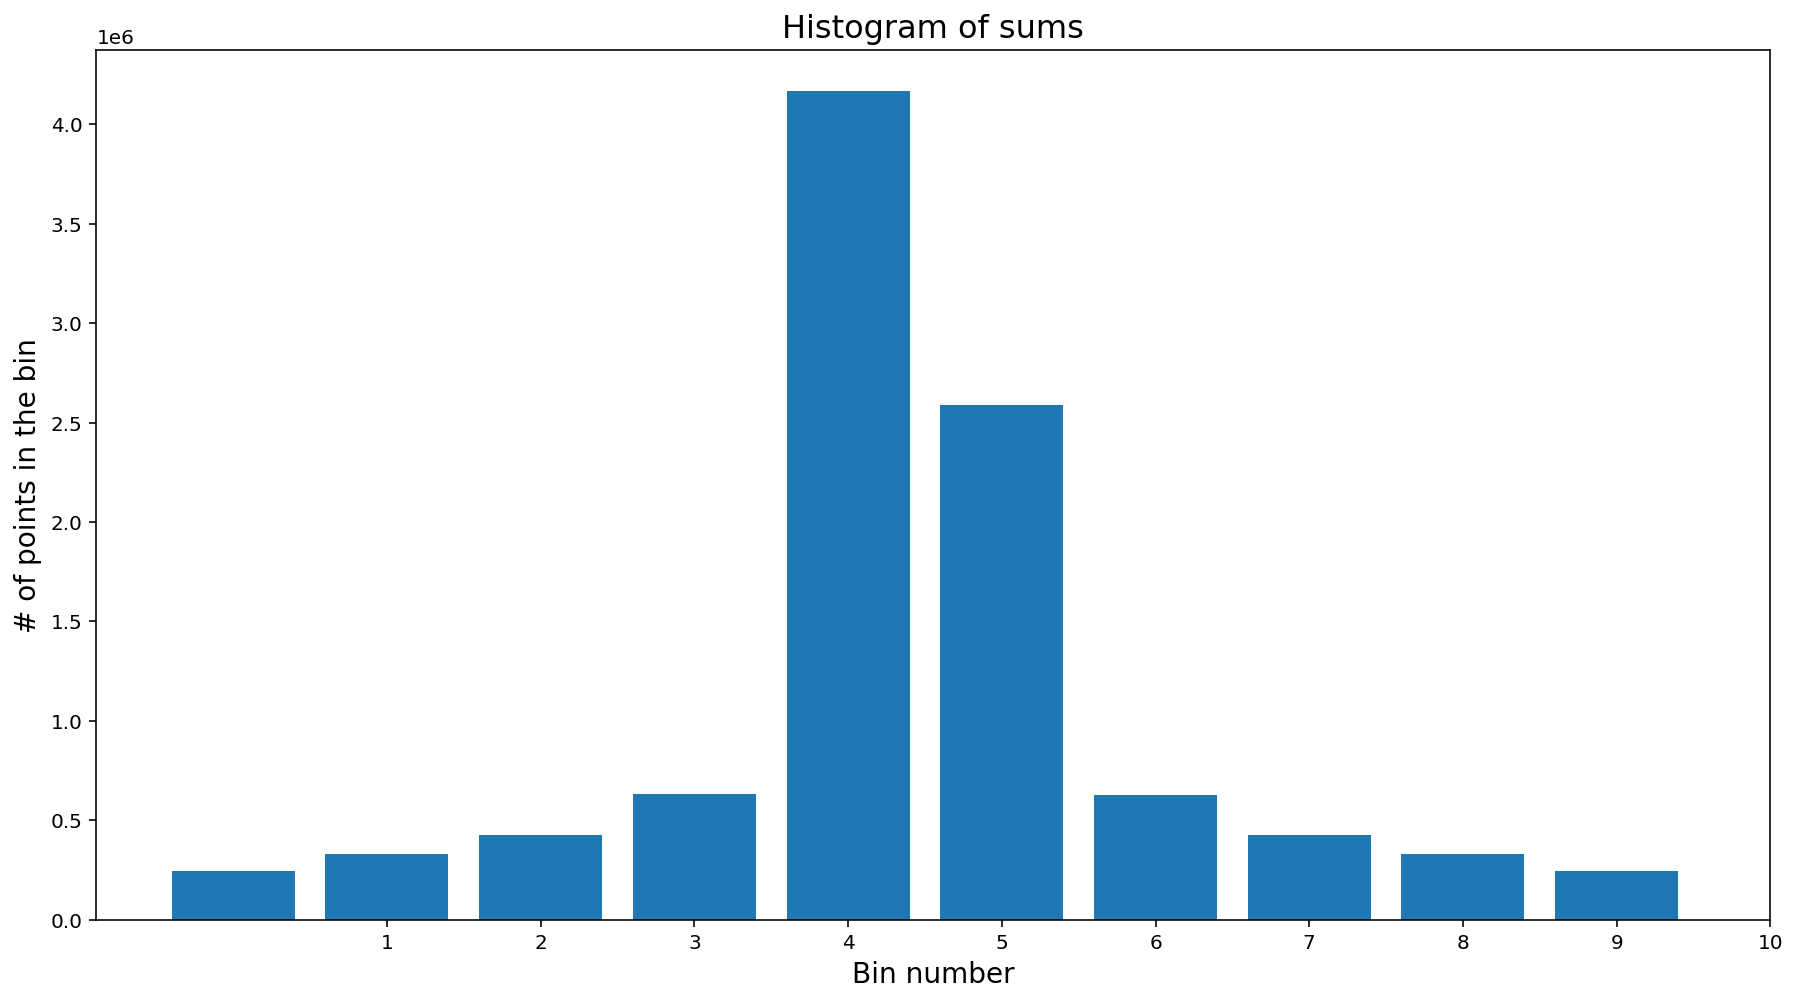

In [5]:
res = []
n_bins = 10
for i in range(n_bins):
    r = ((f_min + (i+1)*delta) > y) & (y > (f_min + i*delta))
    r = cp.sum(r)
    res.append(cp.asnumpy(r))
res = np.array(res)

plt.figure(figsize=(15, 8))
plt.bar(np.arange(10),res)
plt.title('Histogram of sums', fontsize=16)
plt.xlabel('Bin number', fontsize=14)
plt.xticks(range(1, n_bins + 1))
plt.ylabel('# of points in the bin', fontsize=14);

In [6]:
sub_y = ((f_min + delta) > y) & (y > f_min)
np_sub_y = cp.asnumpy(sub_y)

In [7]:
time_sum_cp = %timeit -n 100 -o -q cp.sum(sub_y)
time_sum_cp

<TimeitResult : 10.2 µs ± 837 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [8]:
time_sum_np = %timeit -n 100 -o -q np.sum(np_sub_y)
time_sum_np

<TimeitResult : 4.86 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [9]:
time_sum_cp.average, time_sum_np.average, time_sum_np.average / time_sum_cp.average

(1.0174941437851104e-05, 0.004863059705717855, 477.9447366278807)

Speedup of almost 500 times achieved